In [1]:
!pip install nilearn
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 40.5 MB/s eta 0:00:00


/tmp/ipython-input-2226155833.py:14: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn import datasets, input_data


[fetch_haxby] Added README.md to /root/nilearn_data

[fetch_haxby] Dataset created in /root/nilearn_data/haxby2001

[fetch_haxby] Downloading data from https://www.nitrc.org/frs/download.php/7868/mask.nii.gz ...

[fetch_haxby]  ...done. (1 seconds, 0 min)

[fetch_haxby] Downloading data from http://data.pymvpa.org/datasets/haxby2001/MD5SUMS ...

[fetch_haxby]  ...done. (1 seconds, 0 min)

[fetch_haxby] Downloading data from http://data.pymvpa.org/datasets/haxby2001/subj1-2010.01.14.tar.gz ...

[fetch_haxby] Downloaded 868352 of 314803244 bytes (0.3%%,  6.9min remaining)

[fetch_haxby] Downloaded 13123584 of 314803244 bytes (4.2%%,   49.6s remaining)

[fetch_haxby] Downloaded 27901952 of 314803244 bytes (8.9%%,   32.6s remaining)

[fetch_haxby] Downloaded 43900928 of 314803244 bytes (13.9%%,   25.7s remaining)

[fetch_haxby] Downloaded 61054976 of 314803244 bytes (19.4%%,   21.5s remaining)

[fetch_haxby] Downloaded 77471744 of 314803244 bytes (24.6%%,   18.9s remaining)

[fetch_haxby] Downloaded 94904320 of 314803244 bytes (30.1%%,   16.8s remaining)

[fetch_haxby] Downloaded 110772224 of 314803244 bytes (35.2%%,   15.4s remaining)

[fetch_haxby] Downloaded 126582784 of 314803244 bytes (40.2%%,   14.0s remaining)

[fetch_haxby] Downloaded 143859712 of 314803244 bytes (45.7%%,   12.4s remaining)

[fetch_haxby] Downloaded 162209792 of 314803244 bytes (51.5%%,   10.9s remaining)

[fetch_haxby] Downloaded 179593216 of 314803244 bytes (57.0%%,    9.5s remaining)

[fetch_haxby] Downloaded 197853184 of 314803244 bytes (62.8%%,    8.1s remaining)

[fetch_haxby] Downloaded 215146496 of 314803244 bytes (68.3%%,    6.8s remaining)

[fetch_haxby] Downloaded 233619456 of 314803244 bytes (74.2%%,    5.5s remaining)

[fetch_haxby] Downloaded 251068416 of 314803244 bytes (79.8%%,    4.3s remaining)

[fetch_haxby] Downloaded 269434880 of 314803244 bytes (85.6%%,    3.0s remaining)

[fetch_haxby] Downloaded 286941184 of 314803244 bytes (91.1%%,    1.8s remaining)

[fetch_haxby] Downloaded 303964160 of 314803244 bytes (96.6%%,    0.7s remaining)

[fetch_haxby]  ...done. (21 seconds, 0 min)

[fetch_haxby] Extracting data from 
/root/nilearn_data/haxby2001/9cbdfe22144f858ab0d4958f8162e296/subj1-2010.01.14.tar.gz...

[fetch_haxby] .. done.

/tmp/ipython-input-2226155833.py:46: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  X_all = masker.fit_transform(haxby.func[0])
/tmp/ipython-input-2226155833.py:46: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  X_all = masker.fit_transform(haxby.func[0])


Balanced samples per class:
face: 108
house: 108
scissors: 108
PCA Retained Variance: 94.73%

🔁 Fold 1/12
✅ Fold Accuracy: 100.00%

🔁 Fold 2/12
✅ Fold Accuracy: 100.00%

🔁 Fold 3/12
✅ Fold Accuracy: 100.00%

🔁 Fold 4/12
✅ Fold Accuracy: 100.00%

🔁 Fold 5/12
✅ Fold Accuracy: 100.00%

🔁 Fold 6/12
✅ Fold Accuracy: 100.00%

🔁 Fold 7/12
✅ Fold Accuracy: 92.59%

🔁 Fold 8/12
✅ Fold Accuracy: 100.00%

🔁 Fold 9/12
✅ Fold Accuracy: 100.00%

🔁 Fold 10/12
✅ Fold Accuracy: 100.00%

🔁 Fold 11/12
✅ Fold Accuracy: 92.59%

🔁 Fold 12/12
✅ Fold Accuracy: 100.00%

📊 Mean Accuracy: 98.76543209876543
📊 Std Accuracy: 2.76057774999974

Classification Report:
              precision    recall  f1-score   support

        face       0.98      1.00      0.99       108
       house       0.99      0.99      0.99       108
    scissors       0.99      0.97      0.98       108

    accuracy                           0.99       324
   macro avg       0.99      0.99      0.99       324
weighted avg       0.99      0.

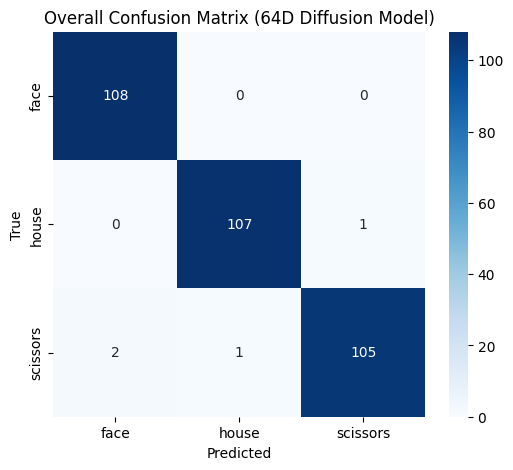

In [2]:
# ==========================================================
# HAXBY fMRI Classification using 64-D Latent Diffusion
# ==========================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import math

from nilearn import datasets, input_data
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# ===============================
# CONFIGURATION
# ===============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_FOLDS = 12
EPOCHS = 30
BATCH_SIZE = 32
LR = 1e-3

PCA_COMPONENTS = 64     # ✅ 64-dimensional features
DIFFUSION_STEPS = 100
SAMPLES_PER_CLASS = 108
CATEGORIES = ["face", "house", "scissors"]

# ===============================
# LOAD HAXBY DATASET
# ===============================
haxby = datasets.fetch_haxby(subjects=[1])
labels_df = pd.read_csv(haxby.session_target[0], sep=" ")

masker = input_data.NiftiMasker(
    mask_img=haxby.mask_vt[0],
    standardize="zscore_sample"
)

X_all = masker.fit_transform(haxby.func[0])

# ===============================
# BALANCE DATASET
# ===============================
np.random.seed(42)

X_balanced = []
y_balanced = []

for idx, cat in enumerate(CATEGORIES):
    indices = np.where(labels_df["labels"] == cat)[0]
    selected = np.random.choice(indices, SAMPLES_PER_CLASS, replace=False)
    X_balanced.append(X_all[selected])
    y_balanced.append(np.full(SAMPLES_PER_CLASS, idx))

X = np.vstack(X_balanced)
y = np.concatenate(y_balanced)

print("Balanced samples per class:")
for i, cat in enumerate(CATEGORIES):
    print(f"{cat}: {np.sum(y == i)}")

# ===============================
# STANDARDIZATION + PCA (64D)
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA Retained Variance: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

# ===============================
# DIFFUSION MODEL
# ===============================

def cosine_beta_schedule(T, s=0.008):
    x = torch.linspace(0, T, T+1)
    alphas = torch.cos(((x / T) + s) / (1+s) * torch.pi / 2)**2
    alphas = alphas / alphas[0]
    betas = 1 - (alphas[1:] / alphas[:-1])
    return torch.clip(betas, 1e-4, 0.999)

betas = cosine_beta_schedule(DIFFUSION_STEPS).to(DEVICE)
alphas = 1 - betas
alpha_hat = torch.cumprod(alphas, dim=0)

def q_sample(z0, t):
    noise = torch.randn_like(z0)
    a = alpha_hat[t].unsqueeze(1)
    return torch.sqrt(a)*z0 + torch.sqrt(1-a)*noise, noise


class DiffusionClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.GELU(),
            nn.Linear(256, 256),
            nn.GELU()
        )
        self.noise_head = nn.Linear(256, feature_dim)
        self.class_head = nn.Linear(256, num_classes)

    def forward(self, x):
        h = self.shared(x)
        return self.noise_head(h), self.class_head(h)

# ===============================
# CROSS VALIDATION
# ===============================
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

fold_acc = []
fold_cms = []
y_preds_total = []
y_trues_total = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_pca)):

    print(f"\n🔁 Fold {fold+1}/{NUM_FOLDS}")

    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = DiffusionClassifier(PCA_COMPONENTS, len(CATEGORIES)).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    mse = nn.MSELoss()
    ce = nn.CrossEntropyLoss()

    train_ds = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_train),
        torch.LongTensor(y_train)
    )

    loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

    # ---------- Training ----------
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in loader:

            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            t = torch.randint(0, DIFFUSION_STEPS, (xb.size(0),), device=DEVICE)
            xt, noise = q_sample(xb, t)

            pred_noise, logits = model(xt)

            loss = 0.7*mse(pred_noise, noise) + 0.3*ce(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # ---------- Evaluation ----------
    model.eval()
    with torch.no_grad():
        logits = model(torch.FloatTensor(X_test).to(DEVICE))[1]
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()

    acc = accuracy_score(y_test, y_pred)
    fold_acc.append(acc)
    fold_cms.append(confusion_matrix(y_test, y_pred))

    y_preds_total.extend(y_pred)
    y_trues_total.extend(y_test)

    print(f"✅ Fold Accuracy: {acc*100:.2f}%")

# ===============================
# FINAL RESULTS
# ===============================

print("\n📊 Mean Accuracy:", np.mean(fold_acc)*100)
print("📊 Std Accuracy:", np.std(fold_acc)*100)

print("\nClassification Report:")
print(classification_report(y_trues_total, y_preds_total, target_names=CATEGORIES))

# ===============================
# CONFUSION MATRIX
# ===============================
plt.figure(figsize=(6,5))
sns.heatmap(
    confusion_matrix(y_trues_total, y_preds_total),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=CATEGORIES, yticklabels=CATEGORIES
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Overall Confusion Matrix (64D Diffusion Model)")
plt.show()
